# Librerías



In [ ]:
#Básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn import preprocessing, model_selection, metrics, ensemble
from timeit import default_timer as timer

#libreria para escribir bonito
from matplotlib.pyplot import rcParams
import matplotlib.patches as mpatches

#Clasificadores
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

#Herramientas clasificadores
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, model_selection, metrics, ensemble
from sklearn.model_selection import cross_val_score


#No me acuerdo equisde
import pickle
import itertools
from collections import Counter
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler


# Pre procesamiento de los datos


## Estos datos ocuparemos para hacer el training y el testeo

In [ ]:
#Importar el paquete drive para importar archivos desde nuestro Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Importamos el csv directamente en un dataframe
dfo = pd.read_csv('/content/drive/My Drive/Modulo_Inter/ALeRCE_ZTF_light_curve_classifications_unlabeled_set_20200609.csv')
#imprimimos parte del DF
print(dfo.shape)
dfo.head()


Printeamos todas las columnas

In [ ]:
for col in dfo.columns: 
    print(col) 

## Se dividen las 15 clases en las 3 clases generales

In [ ]:
#función que hace la clasificación de un dato
def threeclasses(x):
  if x== 'SNIa' or x=='SNIbc' or x=='SNII' or x=='SLSN':
    return 'Transient'
  elif x=='AGN' or x=='QSO' or x=='Blazar' or x=='CV/Nova' or x=='YSO':
    return 'Stochastic'
  elif x=='DSCT' or x=='RRL' or x=='CEP' or x=='LPV' or x=='E' or x=='Periodic-Other':
    return 'Periodic'
  else:
    return None


#se crea una nueva columna 'Clases' aplicando la función definida a la columna 'predicted_classes'
#df['Clases'] = df['predicted_class'].apply(threeclasses)
dfo['Clases'] = dfo['predicted_class'].apply(threeclasses)
#dfo['Clases_numero'] = dfo['Clases'].apply(numero)
dfo.head()

Visualización de la cantidad de datos por cada nueva clase

Clases
Periodic      705659
Stochastic    155513
Transient       7199
Name: objectId, dtype: int64


Text(0, 0.5, 'Clases')

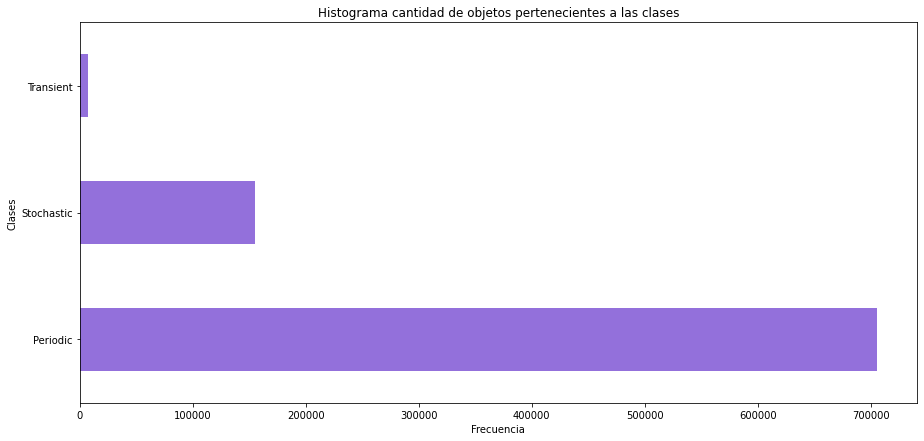

In [ ]:
print(dfo.groupby(['Clases']).count()['objectId'])
# Se hace un histograma que muestre las cantidades de objetos que hay en cada una de las tres clases
fig, ax = plt.subplots(figsize=(15,7))
dfo.groupby(['Clases']).count()['objectId'].plot(kind='barh', color = 'mediumpurple')
ax.set_title('Histograma cantidad de objetos pertenecientes a las clases')
ax.set_xlabel('Frecuencia')
ax.set_ylabel('Clases')

Función para plotear la matriz de confusión

In [ ]:
#@title
from sklearn.utils.multiclass import unique_labels
#Definimos la función para crear matrices de confusión
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Matriz de confusion normalizada'
        else:
            title = 'Matriz de confusion, sin normalizacion'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusion normalizada")
    else:
        print('Matriz de confusion, sin normalizacion')

    print(cm)

    fig, ax = plt.subplots(figsize = (8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta Real',
           xlabel='Etiqueta Predicha')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor", fontsize=8)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), fontsize=8,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            
    ax.grid(False)
    fig.tight_layout()
    return ax

## Detection features

En esta parte, a diferencia de la anterior, se hace uso de los 124 features que son obtenidos usando ZFT y a estas magnitudes se le llaman *atributos de detección*.
Se escriben en un archivo txt de una sola columna y se guarda el Github, se lee el archivo, se hace un reshape y se pasa a una lista de Python que se printea.


In [ ]:
#solo los detection features
columnas1 = pd.read_csv("https://raw.githubusercontent.com/Wenupi/Datos_proyecto/main/detection_feautures").to_numpy().reshape(1,123).tolist()
#solo los non detection features
columnas3= pd.read_csv("https://raw.githubusercontent.com/Wenupi/Datos_proyecto/main/non_detection_feautures").to_numpy().reshape(1,17).tolist()

#print(columnas1.shape)
for i in columnas1:
  print(i)


['delta_period_2', 'IAR_phi_1', 'IAR_phi_2', 'MHPS_PN_flag_1', 'MHPS_PN_flag_2', 'MHPS_high_1', 'MHPS_high_2', 'MHPS_low_1', 'MHPS_low_2', 'MHPS_non_zero_1', 'MHPS_non_zero_2', 'MHPS_ratio_1', 'MHPS_ratio_2', 'positive_fraction_1', 'positive_fraction_2', 'Power_rate_1/2', 'Power_rate_1/3', 'Power_rate_1/4', 'Power_rate_2', 'Power_rate_3', 'Power_rate_4', 'PPE', 'g-r_max', 'g-r_max_corr', 'g-r_mean', 'g-r_mean_corr', 'ExcessVar_1', 'ExcessVar_2', 'GP_DRW_sigma_1', 'GP_DRW_sigma_2', 'GP_DRW_tau_1', 'GP_DRW_tau_2', 'Harmonics_mag_1_1', 'Harmonics_mag_1_2', 'Harmonics_mag_2_1', 'Harmonics_mag_2_2', 'Harmonics_mag_3_1', 'Harmonics_mag_3_2', 'Harmonics_mag_4_1', 'Harmonics_mag_4_2', 'Harmonics_mag_5_1', 'Harmonics_mag_5_2', 'Harmonics_mag_6_1', 'Harmonics_mag_6_2', 'Harmonics_mag_7_1', 'Harmonics_mag_7_2', 'Harmonics_mse_1', 'Harmonics_mse_2', 'Harmonics_phase_2_1', 'Harmonics_phase_2_2', 'Harmonics_phase_3_1', 'Harmonics_phase_3_2', 'Harmonics_phase_4_1', 'Harmonics_phase_4_2', 'Harmonics_p

El output de la celda anterior se copia y pega para crear la lista **columnas_detection** que contiene los nombres de las columnas que se desean seleccionar del DF **dfo**, además se incluye la columna *Clases* para crear el DF **df_detection**.

In [ ]:
#Se crea un df_detection que contendrá los objetos del DataFrame dfo pero considerando solo las 124 columnas detection
df_detection = dfo.copy()
columnas_detection=['objectId', 'delta_period_2', 'IAR_phi_1', 'IAR_phi_2', 'MHPS_PN_flag_1', 'MHPS_PN_flag_2', 'MHPS_high_1', 'MHPS_high_2', 'MHPS_low_1', 'MHPS_low_2', 'MHPS_non_zero_1', 'MHPS_non_zero_2', 'MHPS_ratio_1', 'MHPS_ratio_2', 'positive_fraction_1', 'positive_fraction_2', 'Power_rate_1/2', 'Power_rate_1/3', 'Power_rate_1/4', 'Power_rate_2', 'Power_rate_3', 'Power_rate_4', 'PPE', 'g-r_max_corr', 'g-r_mean', 'g-r_mean_corr', 'ExcessVar_1', 'ExcessVar_2', 'GP_DRW_sigma_1', 'GP_DRW_sigma_2', 'GP_DRW_tau_1', 'GP_DRW_tau_2', 'Harmonics_mag_1_1', 'Harmonics_mag_1_2', 'Harmonics_mag_2_1', 'Harmonics_mag_2_2', 'Harmonics_mag_3_1', 'Harmonics_mag_3_2', 'Harmonics_mag_4_1', 'Harmonics_mag_4_2', 'Harmonics_mag_5_1', 'Harmonics_mag_5_2', 'Harmonics_mag_6_1', 'Harmonics_mag_6_2', 'Harmonics_mag_7_1', 'Harmonics_mag_7_2', 'Harmonics_mse_1', 
       'Harmonics_mse_2', 'Harmonics_phase_2_1', 'Harmonics_phase_2_2', 'Harmonics_phase_3_1', 'Harmonics_phase_3_2', 'Harmonics_phase_4_1', 'Harmonics_phase_4_2', 'Harmonics_phase_5_1', 'Harmonics_phase_5_2', 'Harmonics_phase_6_1', 'Harmonics_phase_6_2', 'Harmonics_phase_7_1', 'Harmonics_phase_7_2', 'Multiband_period', 'Pvar_1', 'Pvar_2', 'SF_ML_amplitude_1', 'SF_ML_amplitude_2', 'SF_ML_gamma_1', 'SF_ML_gamma_2', 'SPM_A_1', 'SPM_A_2', 'SPM_beta_1', 'SPM_beta_2', 'SPM_chi_1', 'SPM_chi_2', 'SPM_gamma_1', 'SPM_gamma_2', 'SPM_t0_1', 'SPM_t0_2', 'SPM_tau_fall_1', 'SPM_tau_fall_2', 'SPM_tau_rise_1', 'SPM_tau_rise_2', 'Amplitude_1', 'Amplitude_2', 
       'AndersonDarling_1', 'AndersonDarling_2', 'Autocor_length_1', 'Autocor_length_2', 'Con_1', 'Con_2', 'Eta_e_1', 'Eta_e_2', 'Gskew_1', 'Gskew_2', 'LinearTrend_1', 'LinearTrend_2', 'MaxSlope_1', 'MaxSlope_2', 'Meanvariance_1', 'Meanvariance_2', 'MedianAbsDev_1', 'MedianAbsDev_2', 'MedianBRP_1', 'MedianBRP_2', 'PairSlopeTrend_1', 'PairSlopeTrend_2', 'PercentAmplitude_1', 'PercentAmplitude_2', 'Psi_CS_1', 'Psi_CS_2', 'Psi_eta_1', 'Psi_eta_2', 'Q31_1', 'Q31_2', 'Rcs_1', 'Rcs_2', 'Skew_1', 'Skew_2', 'SmallKurtosis_1', 'SmallKurtosis_2', 'Std_1', 'Std_2', 'StetsonK_1', 'StetsonK_2', 'predicted_class', 'Clases']
df_detection = df_detection[columnas_detection].dropna()

print(df_detection.shape)

## Detection y non detection features (all features)

Se separa ahora un DataFrame más grande que contendrá 142 atributos, la diferencia con el anterior es que este, considera columnas detection y 18 columnas non-detection. Al conjunto de atributos detection y non-detection les llamaremos all-detection.


In [ ]:
for i in columnas3:
  print(i)

['dmag_first_det_fid_2', 'dmag_non_det_fid_1', 'dmag_non_det_fid_2', 'last_diffmaglim_before_fid_1', 'last_diffmaglim_before_fid_2', 'max_diffmaglim_before_fid_1', 'max_diffmaglim_before_fid_2', 'max_diffmaglim_after_fid_1', 'max_diffmaglim_after_fid_2', 'median_diffmaglim_after_fid_1', 'median_diffmaglim_after_fid_2', 'median_diffmaglim_before_fid_1', 'median_diffmaglim_before_fid_2', 'n_non_det_after_fid_1', 'n_non_det_after_fid_2', 'n_non_det_before_fid_1', 'n_non_det_before_fid_2']


In [ ]:
#Se define el DataFrame con los objetos del DF dfo con las 142 columnas all-detection
df_alldetection_pre = dfo.copy()
columnas_non_detection = ['dmag_first_det_fid_2', 'dmag_non_det_fid_1', 'dmag_non_det_fid_2', 'last_diffmaglim_before_fid_1', 'last_diffmaglim_before_fid_2', 'max_diffmaglim_before_fid_1', 'max_diffmaglim_before_fid_2', 'max_diffmaglim_after_fid_1', 'max_diffmaglim_after_fid_2', 'median_diffmaglim_after_fid_1', 'median_diffmaglim_after_fid_2', 'median_diffmaglim_before_fid_1', 'median_diffmaglim_before_fid_2', 'n_non_det_after_fid_1', 'n_non_det_after_fid_2', 'n_non_det_before_fid_1', 'n_non_det_before_fid_2']
columnas_alldetection = columnas_detection + columnas_non_detection
df_alldetection_pre = df_alldetection_pre[columnas_alldetection].dropna()

print(df_alldetection_pre.shape)

Ahora se grafica un nuevo histograma que mostrará la cantidad de objetos que existen en las tres clases principales, considerando solo los objetos sin valores NaN  de las columnas all-detection.

Clases
Periodic      159114
Stochastic     30340
Transient        776
Name: objectId, dtype: int64


Text(0, 0.5, 'Clases')

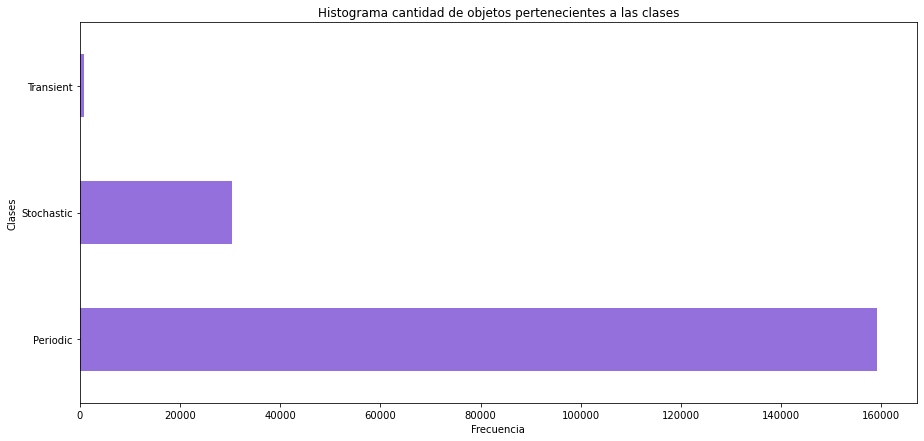

In [ ]:
print(df_alldetection_pre.groupby(['Clases']).count()['objectId'])
# Se grafica el histograma
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
df_alldetection_pre.groupby(['Clases']).count()['objectId'].plot(kind='barh', color = 'mediumpurple')
ax.set_title('Histograma cantidad de objetos pertenecientes a las clases')
ax.set_xlabel('Frecuencia')
ax.set_ylabel('Clases')

Ahora, se crean 3 conjuntos de objetos tal que se obtenga la misma cantidad de objetos para cada una de las tres clases.

In [ ]:
transientes_alldetection = df_alldetection_pre.loc[df_alldetection_pre['Clases']=='Transient'].sample(n=776)
periodicos_alldetection = df_alldetection_pre.loc[df_alldetection_pre['Clases']=='Periodic'].sample(n=776)
estocasticos_alldetection = df_alldetection_pre.loc[df_alldetection_pre['Clases']=='Stochastic'].sample(n=776)

df_alldetection = pd.concat([transientes_alldetection, periodicos_alldetection, estocasticos_alldetection])
df_alldetection.shape

(2328, 142)

In [ ]:
#Se le asigna un número a cada una de las clases para definir más fácilmente los arreglos para la clasificación
clases_alldetection = df_alldetection['Clases'].unique()
mapa_alldetection = {}
for clase, i in enumerate(clases_alldetection):
    mapa_alldetection[i] = clase
mapa_alldetection

{'Transient': 0, 'Periodic': 1, 'Stochastic': 2}

Clasificación con clases balanceadas

Para el clasificador random forest:
Cross validation promedio:  0.939
Cross validation std:       0.009
Accuracy: 0.9362808842652796
Balanced accuracy: 0.9336123162982003
Matriz de confusion normalizada
[[0.96138996 0.003861   0.03474903]
 [0.         0.97080292 0.02919708]
 [0.02118644 0.11016949 0.86864407]]


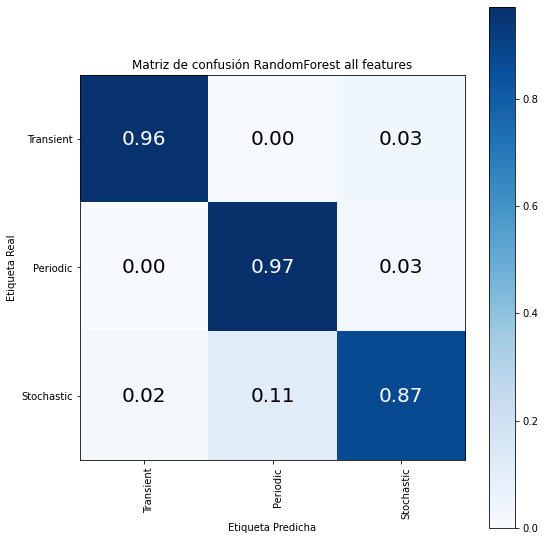

In [ ]:
# creación de los arreglos de atributos y clases
X_alldetection = df_alldetection.drop(['objectId', 'predicted_class',"Clases"], axis=1)
y_alldetection = np.array(df_alldetection['Clases'].map(mapa_alldetection))


# separación en testeo y prueba
X_train_alldetection, X_test_alldetection, y_train_alldetection, y_test_alldetection = train_test_split(X_alldetection, y_alldetection, test_size=0.33, random_state=66)

# se llama al clasificador
rfc_alldetection = RandomForestClassifier() 
# entrenamiento del modelo
rfc_alldetection.fit(X_train_alldetection,y_train_alldetection)
# predicciones
rfc_predict_alldetection = rfc_alldetection.predict(X_test_alldetection)

#cross value
scores1_alldetection = cross_val_score(rfc_alldetection, X_alldetection, y_alldetection, cv=4, scoring='accuracy')
print('Para el clasificador random forest:')
print('Cross validation promedio: ', format(scores1_alldetection.mean(), '.3f'))
print('Cross validation std:      ', format(scores1_alldetection.std(), '.3f'))
print("Accuracy:", metrics.accuracy_score(y_test_alldetection, rfc_predict_alldetection))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_alldetection, rfc_predict_alldetection))
#clases_alldetection = df_alldetection['Clases'].unique()
#matriz de confusión 
plot_confusion_matrix2(y_test_alldetection, rfc_predict_alldetection, classes=clases_alldetection, normalize = True,
                      title='Matriz de confusión RandomForest all features')


## 42 atributos FATS

42 atributos recomendados para estudiar objetos variables, muestran características de las curvas de luz. Se realiza **el mismo procedimiento**

# Clasificación con atributos FATS para 190mil objetos

In [ ]:
# Se definen las 22 columnas de atributos FATS
columnas_FATS_pre= pd.read_csv('https://raw.githubusercontent.com/Wenupi/Datos_proyecto/main/FATS_features').to_numpy().reshape(1,41).tolist()

#print(columnas1.shape)
for i in columnas_FATS_pre:
  print(i)



['Amplitude_2', 'AndersonDarling_1', 'AndersonDarling_2', 'Autocor_length_1', 'Autocor_length_2', 'Con_1', 'Con_2', 'Eta_e_1', 'Eta_e_2', 'Gskew_1', 'Gskew_2', 'LinearTrend_1', 'LinearTrend_2', 'MaxSlope_1', 'MaxSlope_2', 'Meanvariance_1', 'Meanvariance_2', 'MedianAbsDev_1', 'MedianAbsDev_2', 'MedianBRP_1', 'MedianBRP_2', 'PairSlopeTrend_1', 'PairSlopeTrend_2', 'PercentAmplitude_1', 'PercentAmplitude_2', 'Psi_CS_1', 'Psi_CS_2', 'Psi_eta_1', 'Psi_eta_2', 'Q31_1', 'Q31_2', 'Rcs_1', 'Rcs_2', 'Skew_1', 'Skew_2', 'SmallKurtosis_1', 'SmallKurtosis_2', 'Std_1', 'Std_2', 'StetsonK_1', 'StetsonK_2']


In [ ]:
#Se crea un DataFrame con los 190mil objetos que quedaron luego de quitar los NaN de las columnas all-detection pero considerando solo los atributos FATS
df_22 = df_alldetection_pre.copy()
columnas_FATS = ['objectId','Amplitude_2', 'AndersonDarling_1', 'AndersonDarling_2', 'Autocor_length_1', 'Autocor_length_2', 'Con_1', 'Con_2', 'Eta_e_1', 'Eta_e_2', 'Gskew_1', 'Gskew_2', 'LinearTrend_1', 'LinearTrend_2', 'MaxSlope_1', 'MaxSlope_2', 'Meanvariance_1', 'Meanvariance_2', 'MedianAbsDev_1', 'MedianAbsDev_2', 
                 'MedianBRP_1', 'MedianBRP_2', 'PairSlopeTrend_1', 'PairSlopeTrend_2', 'PercentAmplitude_1', 'PercentAmplitude_2', 'Psi_CS_1', 'Psi_CS_2', 'Psi_eta_1', 'Psi_eta_2', 'Q31_1', 'Q31_2', 'Rcs_1', 'Rcs_2', 'Skew_1', 'Skew_2', 'SmallKurtosis_1', 'SmallKurtosis_2', 'Std_1', 'Std_2', 'StetsonK_1', 'StetsonK_2','predicted_class',"Clases"]
df_22 = df_22[columnas_FATS].dropna()
print(df_22.shape)
df_22.head()

In [ ]:
# Se definen las clases como números para luego definir los arreglos de atributos
clases_22 = df_22['Clases'].unique()
mapa_22 = {}
for clase, i in enumerate(clases_22):
    mapa_22[i] = clase
mapa_22

{'Periodic': 0, 'Stochastic': 1, 'Transient': 2}

Se realiza la clasificación para los atributos FATS, considerando el tiempo que se demora en correr, el cross validation y el accuracy. Como se utilian los 190000 objetos, las clases no están balanceadas, por lo que es necesario usar el clasificador BalancedRandomForest

In [ ]:
start = timer()
# creación de los arreglos de atributos y clases
X_22 = df_22.drop(['objectId', 'predicted_class',"Clases"], axis=1)
y_22 = np.array(df_22['Clases'].map(mapa_22))

#np.array(df_alldetection['Clases'].map(mapa_alldetection))

# separación en testeo y prueba
X_train_22, X_test_22, y_train_22, y_test_22 = train_test_split(X_22, y_22, test_size=0.33, random_state=66)

# se llama al clasificador
rfc_22 = BalancedRandomForestClassifier() 
# entrenamiento del modelo
rfc_22.fit(X_train_22,y_train_22)
# predicciones
rfc_predict_22 = rfc_22.predict(X_test_22)

#cross value
scores1_22 = cross_val_score(rfc_22, X_22, y_22, cv=4, scoring='accuracy')
print('Para el clasificador random forest:')
print('Cross validation promedio: ', format(scores1_22.mean(), '.3f'))
print('Cross validation std:      ', format(scores1_22.std(), '.3f'))
print("Accuracy:", metrics.accuracy_score(y_test_22, rfc_predict_22))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_22, rfc_predict_22))

#clases_22 = df_22['Clases'].unique()
#matriz de confusión 
plot_confusion_matrix2(y_test_22, rfc_predict_22, classes=clases_22, normalize = True,
                      title='Matriz de confusión BalancedRandomForest FATS features')
print('Tiempo que toma correrlo:')
end = timer()
print(end - start)

# Clasificación con atributos all-detection para 190mil objetos

Ahora se realiza la predicción con la máxima cantidad de objetos (190.000) para clasificar en las 3 clases generales para atributos **all-detection**, como se utilizan todos los datos, es necesario usar el clasificador BalancedRandomForest

In [ ]:
#Se definen nuevamente las clases como números para luego definir los arreglos
clases_alldetection_all = df_alldetection_pre['Clases'].unique()

mapa_alldetection_all = {}

for clase, i in enumerate(clases_alldetection_all):
    mapa_alldetection_all[i] = clase
mapa_alldetection_all

{'Periodic': 0, 'Stochastic': 1, 'Transient': 2}

Se realiza la clasificación para 190000 objetos con atributos all-detection considerando el tiempo que se demora en correr, accuracy y cross validation.

Para el clasificador BalancedRandomForest:
Cross validation promedio:  0.942
Cross validation std:       0.001
Accuracy: 0.9381929399770613
Balanced accuracy: 0.9294773138898814
Matriz de confusion normalizada
[[0.95102764 0.04640088 0.00257148]
 [0.11678832 0.870013   0.01319868]
 [0.00362319 0.02898551 0.9673913 ]]
Tiempo que toma correrolo:
71.18527407600004


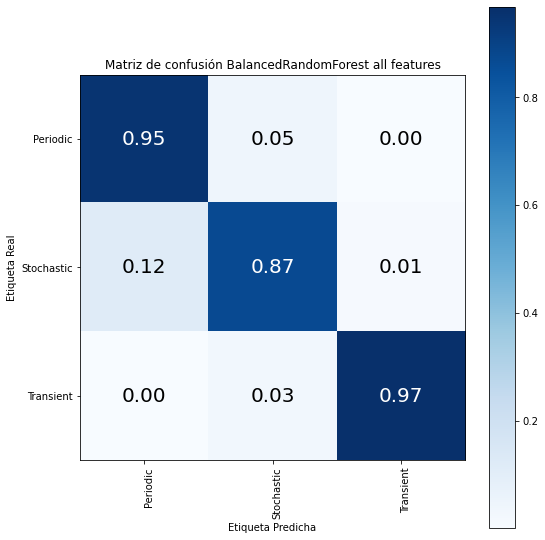

In [ ]:
# creación de los arreglos de atributos y clases

start = timer()

X_alldetection_all = df_alldetection_pre.drop(['objectId', 'predicted_class',"Clases"], axis=1)
y_alldetection_all = np.array(df_alldetection_pre['Clases'].map(mapa_alldetection_all))

# separación en testeo y prueba
X_train_alldetection_all, X_test_alldetection_all, y_train_alldetection_all, y_test_alldetection_all = train_test_split(X_alldetection_all, y_alldetection_all, test_size=0.33, random_state=66)

# se llama al clasificador BalancedRandomForest
rfc_alldetection_all = BalancedRandomForestClassifier() 
# entrenamiento del modelo
rfc_alldetection_all.fit(X_train_alldetection_all,y_train_alldetection_all)
# predicciones
rfc_predict_alldetection_all = rfc_alldetection_all.predict(X_test_alldetection_all)

#cross value
scores1_alldetection_all = cross_val_score(rfc_alldetection_all, X_alldetection_all, y_alldetection_all, cv=4, scoring='accuracy')
print('Para el clasificador BalancedRandomForest:')
print('Cross validation promedio: ', format(scores1_alldetection_all.mean(), '.3f'))
print('Cross validation std:      ', format(scores1_alldetection_all.std(), '.3f'))
print("Accuracy:", metrics.accuracy_score(y_test_alldetection_all, rfc_predict_alldetection_all))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_alldetection_all, rfc_predict_alldetection_all))

#clases_alldetection_all = df_alldetection_all['Clases'].unique()
#matriz de confusión 
plot_confusion_matrix2(y_test_alldetection_all, rfc_predict_alldetection_all, classes=clases_alldetection_all, normalize = True,
                      title='Matriz de confusión BalancedRandomForest all features')

print('Tiempo que toma correrlo:')
end = timer()
print(end - start)

De la clasificación con atributos all-detection, se utiliza la función feature_importances para definir la importancia de los atributos en la clasificación realizada.

In [ ]:
feature_importances = pd.DataFrame(rfc_alldetection_all.feature_importances_,
                                   index = X_train_alldetection_all.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

hola = feature_importances.index.to_numpy().tolist()
print(hola)

['SPM_tau_rise_2', 'SPM_tau_rise_1', 'LinearTrend_1', 'positive_fraction_1', 'SPM_chi_2', 'n_non_det_after_fid_2', 'SPM_A_2', 'LinearTrend_2', 'dmag_non_det_fid_2', 'SPM_beta_1', 'SPM_t0_1', 'dmag_first_det_fid_2', 'SPM_tau_fall_1', 'SPM_tau_fall_2', 'positive_fraction_2', 'g-r_mean', 'SPM_beta_2', 'ExcessVar_2', 'SPM_chi_1', 'Pvar_2', 'IAR_phi_1', 'n_non_det_after_fid_1', 'ExcessVar_1', 'MHPS_low_2', 'dmag_non_det_fid_1', 'SPM_t0_2', 'g-r_mean_corr', 'Rcs_2', 'SF_ML_amplitude_1', 'max_diffmaglim_after_fid_2', 'MHPS_high_2', 'Meanvariance_2', 'Power_rate_4', 'g-r_max_corr', 'Meanvariance_1', 'Power_rate_3', 'Rcs_1', 'GP_DRW_sigma_2', 'SPM_A_1', 'GP_DRW_tau_1', 'Amplitude_2', 'IAR_phi_2', 'GP_DRW_sigma_1', 'MHPS_high_1', 'Pvar_1', 'Std_2', 'MHPS_low_1', 'Power_rate_1/2', 'SF_ML_amplitude_2', 'PercentAmplitude_1', 'Q31_1', 'Amplitude_1', 'Std_1', 'GP_DRW_tau_2', 'Harmonics_mse_1', 'Multiband_period', 'Psi_CS_2', 'Power_rate_2', 'median_diffmaglim_after_fid_1', 'PPE', 'SF_ML_gamma_2', 'SF

In [ ]:
mejores_atributos_3 = ['objectId', 'SPM_tau_rise_2', 'SPM_tau_rise_1', 'LinearTrend_1', 'positive_fraction_1', 'SPM_chi_2', 'n_non_det_after_fid_2', 'SPM_A_2', 'LinearTrend_2', 'dmag_non_det_fid_2', 'SPM_beta_1', 'SPM_t0_1', 'dmag_first_det_fid_2', 'SPM_tau_fall_1', 'SPM_tau_fall_2', 'positive_fraction_2', 'g-r_mean', 'SPM_beta_2', 'ExcessVar_2', 'SPM_chi_1', 'Pvar_2', 'IAR_phi_1', 'n_non_det_after_fid_1', 'ExcessVar_1', 'MHPS_low_2', 
                       'dmag_non_det_fid_1', 'SPM_t0_2', 'g-r_mean_corr', 'Rcs_2', 'SF_ML_amplitude_1', 'max_diffmaglim_after_fid_2', 'MHPS_high_2', 'Meanvariance_2', 'Power_rate_4', 'g-r_max_corr', 'Meanvariance_1', 'Power_rate_3', 'Rcs_1', 'GP_DRW_sigma_2', 'SPM_A_1', 'GP_DRW_tau_1', 'Amplitude_2', 'IAR_phi_2', 'GP_DRW_sigma_1', 'MHPS_high_1', 'Pvar_1', 'Std_2', 'MHPS_low_1', 'Power_rate_1/2', 'SF_ML_amplitude_2', 'PercentAmplitude_1', "Clases",'predicted_class']
print(len(mejores_atributos_3))

53


Conociendo los mejores atributos, se realiza ahora la clasificación de los 190000 objetos considerando un DataFrame solo con estos 50 mejores atributos

In [ ]:
#Se define el DataFrame que se usará en la clasificación
df_mejores_atributos_3 = df_alldetection_pre.copy()
df_mejores_atributos_3 = df_mejores_atributos_3[mejores_atributos_3]
print(df_mejores_atributos_3.shape)
df_mejores_atributos_3.head()

Para el clasificador BalancedRandomForest:
Cross validation promedio:  0.941
Cross validation std:       0.001
Accuracy: 0.9349592200841086
Balanced accuracy: 0.9260014855519959
Matriz de confusion normalizada
[[0.94704661 0.05089621 0.00205718]
 [0.11528847 0.87081292 0.01389861]
 [0.         0.03985507 0.96014493]]
Tiempo que toma correrlo:
55.040676295000594


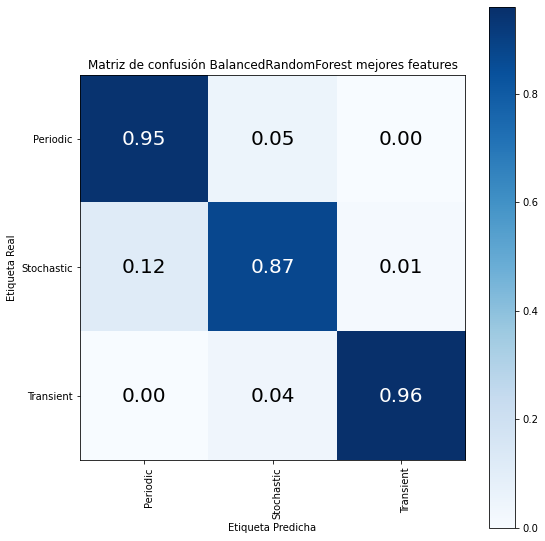

In [ ]:
# creación de los arreglos de atributos y clases

start = timer()

X_mejores_atributos_3 = df_mejores_atributos_3.drop(['objectId', 'predicted_class',"Clases"], axis=1)
y_mejores_atributos_3 = np.array(df_mejores_atributos_3['Clases'].map(mapa_alldetection_all))

# separación en testeo y prueba
X_train_mejores_atributos_3, X_test_mejores_atributos_3, y_train_mejores_atributos_3, y_test_mejores_atributos_3 = train_test_split(X_mejores_atributos_3, y_mejores_atributos_3, test_size=0.33, random_state=66)

# se llama al clasificador
rfc_mejores_atributos_3 = BalancedRandomForestClassifier() 
# entrenamiento del modelo
rfc_mejores_atributos_3.fit(X_train_mejores_atributos_3,y_train_mejores_atributos_3)
# predicciones
rfc_predict_mejores_atributos_3 = rfc_mejores_atributos_3.predict(X_test_mejores_atributos_3)

#cross value
scores1_mejores_atributos_3 = cross_val_score(rfc_mejores_atributos_3, X_mejores_atributos_3, y_mejores_atributos_3, cv=4, scoring='accuracy')
print('Para el clasificador BalancedRandomForest:')
print('Cross validation promedio: ', format(scores1_mejores_atributos_3.mean(), '.3f'))
print('Cross validation std:      ', format(scores1_mejores_atributos_3.std(), '.3f'))
print("Accuracy:", metrics.accuracy_score(y_test_mejores_atributos_3, rfc_predict_mejores_atributos_3))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_mejores_atributos_3, rfc_predict_mejores_atributos_3))

#clases_mejores_atributos_3 = df_mejores_atributos_3['Clases'].unique()
#matriz de confusión 
plot_confusion_matrix2(y_test_mejores_atributos_3, rfc_predict_mejores_atributos_3, classes=clases_alldetection_all, normalize = True,
                      title='Matriz de confusión BalancedRandomForest mejores features')

print('Tiempo que toma correrlo:')
end = timer()
print(end - start)

# Clasificación para las 15 clases

##Se realiza nuevamente la clasificación de los 190000 objetos, pero esta vez para las 15 clases que se tenían originalmente. Se usarán los mismos grupos de atributos: all-detection, FATS y los 50 mejores de la clasificación con all-detection. Ya que las clases no están balanceadas, se usará el clasificador BalancedRandomForest

In [ ]:
# Se define el DataFrame con columnas all-detection 
df_15features_pre = dfo.copy()
df_15features = df_15features_pre[columnas_alldetection].dropna()
print(df_15features.shape)
df_15features.head()


(190230, 142)


,objectId,delta_period_2,IAR_phi_1,IAR_phi_2,MHPS_PN_flag_1,MHPS_PN_flag_2,MHPS_high_1,MHPS_high_2,MHPS_low_1,MHPS_low_2,...,max_diffmaglim_after_fid_1,max_diffmaglim_after_fid_2,median_diffmaglim_after_fid_1,median_diffmaglim_after_fid_2,median_diffmaglim_before_fid_1,median_diffmaglim_before_fid_2,n_non_det_after_fid_1,n_non_det_after_fid_2,n_non_det_before_fid_1,n_non_det_before_fid_2
0,ZTF17aaaaavn,0.489561,9.986089e-01,4.230063e-13,0.0,0.0,0.104758,0.021977,5.156645,0.242537,...,21.125200,21.026400,20.535049,20.421249,20.601999,20.340149,272.0,284.0,9.0,34.0
6,ZTF17aaabbhy,0.002991,2.052784e-03,4.798818e-13,0.0,0.0,0.000614,0.000755,0.005311,0.002333,...,21.060301,21.026400,20.446699,20.355101,20.719200,19.536400,253.0,413.0,7.0,2.0
7,ZTF17aaabmwq,0.316716,2.746699e-06,1.177661e-11,0.0,0.0,0.016888,0.001562,0.033616,0.023678,...,20.891899,20.830299,20.007151,19.990900,20.387400,20.629299,164.0,229.0,13.0,3.0
8,ZTF17aaabrhj,0.037156,4.230063e-13,4.230063e-13,0.0,0.0,0.000869,0.000297,0.246175,0.092951,...,21.163799,20.973600,20.368900,20.390699,20.253401,20.164301,219.0,229.0,21.0,3.0
9,ZTF17aaabxwz,0.000003,2.136414e-01,6.582883e-01,0.0,0.0,0.120007,0.025479,1.066551,0.328515,...,20.722799,20.691601,19.900801,19.712151,20.086700,20.283100,143.0,118.0,2.0,7.0


Se hace un histograma para conocer la cantidad de objetos que hay por cada una de las 15 clases

In [ ]:

print(df_15features.groupby(['predicted_class']).count()['objectId'])
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
df_15features.groupby(['Clases']).count()['objectId'].plot(kind='barh', color = 'mediumpurple')
ax.set_title('Histograma cantidad de objetos pertenecientes a las clases')
ax.set_xlabel('Frecuencia')
ax.set_ylabel('Clases')

In [ ]:
#A cada una de las 15 clases se le asigna un número para facilitar la definición de los arreglos necesarios para hacer las clasificaciones 
clases_15features = df_15features['predicted_class'].unique()

mapa_15features = {}

for clase, i in enumerate(clases_15features):
    mapa_15features[i] = clase
mapa_15features

{'Periodic-Other': 0,
 'E': 1,
 'CV/Nova': 2,
 'CEP': 3,
 'LPV': 4,
 'YSO': 5,
 'RRL': 6,
 'DSCT': 7,
 'QSO': 8,
 'Blazar': 9,
 'AGN': 10,
 'SNII': 11,
 'SNIa': 12,
 'SNIbc': 13,
 'SLSN': 14}

In [ ]:
df_15features_sample = df_15features.copy().sample(n=190230)

Se realiza la clasificación para ls 15 clases con los atributos all-detection, considerando el tiempo que se demora en correr, accuracy y cross validaton. 

Para el clasificador random forest:
Cross validation promedio:  0.771
Cross validation std:       0.001
Accuracy: 0.7646871415827705
Balanced accuracy: 0.7316969967771623
Matriz de confusion normalizada
[[7.81894966e-01 8.01035352e-02 1.36230502e-04 2.24099176e-02
  2.43852599e-02 7.17253593e-02 5.44922008e-04 4.08691506e-03
  2.11157278e-03 2.38403379e-03 1.00129419e-02 0.00000000e+00
  6.81152510e-05 1.36230502e-04 0.00000000e+00]
 [7.82881002e-02 6.56054280e-01 3.44467641e-03 6.83716075e-02
  1.04384134e-04 2.41127349e-02 2.67745303e-02 1.34498956e-01
  2.29645094e-03 1.72233820e-03 4.12317328e-03 0.00000000e+00
  0.00000000e+00 1.04384134e-04 1.04384134e-04]
 [1.59151194e-02 7.95755968e-03 6.52519894e-01 6.63129973e-03
  0.00000000e+00 1.72413793e-02 1.85676393e-02 1.98938992e-02
  1.00795756e-01 9.28381963e-02 5.03978780e-02 5.30503979e-03
  3.97877984e-03 5.30503979e-03 2.65251989e-03]
 [1.11111111e-02 1.72839506e-02 3.08641975e-02 8.49382716e-01
  3.33333333e-02 1.60493827e-02 3

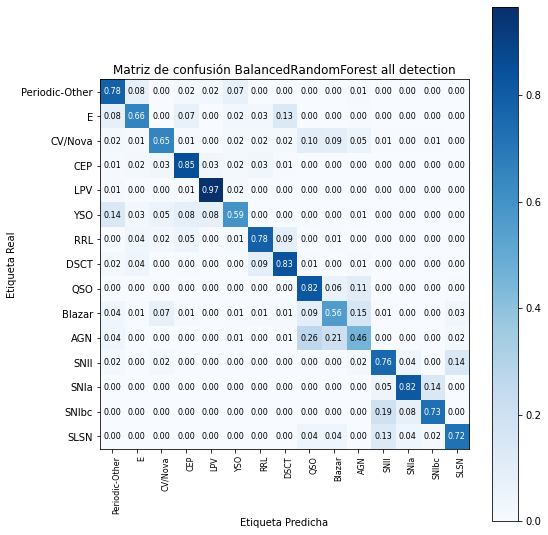

In [ ]:
start = timer()
# creación de los arreglos de atributos y clases
X_15features = df_15features_sample.drop(['objectId', "Clases",'predicted_class'], axis=1)
y_15features = np.array(df_15features_sample['predicted_class'].map(mapa_15features))

# separación en testeo y prueba
X_train_15features, X_test_15features, y_train_15features, y_test_15features = train_test_split(X_15features, y_15features, test_size=0.33, random_state=66)

# se llama al clasificador
rfc_15features = BalancedRandomForestClassifier() 
# entrenamiento del modelo
rfc_15features.fit(X_train_15features,y_train_15features)
# predicciones
rfc_predict_15features = rfc_15features.predict(X_test_15features)

#cross value
scores1_15features = cross_val_score(rfc_15features, X_15features, y_15features, cv=4, scoring='accuracy')
print('Para el clasificador random forest:')
print('Cross validation promedio: ', format(scores1_15features.mean(), '.3f'))
print('Cross validation std:      ', format(scores1_15features.std(), '.3f'))
print("Accuracy:", metrics.accuracy_score(y_test_15features, rfc_predict_15features))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_15features, rfc_predict_15features))


#matriz de confusión 
plot_confusion_matrix(y_test_15features, rfc_predict_15features, classes=clases_15features, normalize = True,
                      title='Matriz de confusión BalancedRandomForest all detection')
print('Tiempo que toma correrlo:')
end = timer()
print(end - start)

Se definen los 50 atributos más importantes en la clasificación recién hecha

In [ ]:
feature_importances15 = pd.DataFrame(rfc_15features.feature_importances_,
                                   index = X_train_15features.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

hola15 = feature_importances15.index.to_numpy().tolist()
print(hola15)

['g-r_max_corr', 'g-r_mean_corr', 'g-r_mean', 'Multiband_period', 'IAR_phi_1', 'SPM_tau_rise_1', 'dmag_non_det_fid_2', 'Meanvariance_1', 'SPM_tau_rise_2', 'SPM_t0_1', 'SPM_A_2', 'Amplitude_1', 'IAR_phi_2', 'LinearTrend_1', 'Std_1', 'SPM_beta_1', 'ExcessVar_1', 'GP_DRW_tau_2', 'Meanvariance_2', 'PercentAmplitude_1', 'SPM_chi_2', 'SPM_tau_fall_1', 'Std_2', 'GP_DRW_sigma_1', 'dmag_first_det_fid_2', 'Q31_1', 'SPM_chi_1', 'Amplitude_2', 'n_non_det_after_fid_1', 'PercentAmplitude_2', 'SF_ML_amplitude_1', 'MHPS_high_2', 'MHPS_low_2', 'n_non_det_after_fid_2', 'SPM_A_1', 'ExcessVar_2', 'Rcs_1', 'GP_DRW_tau_1', 'SPM_beta_2', 'GP_DRW_sigma_2', 'MedianAbsDev_1', 'MHPS_low_1', 'positive_fraction_1', 'dmag_non_det_fid_1', 'SPM_tau_fall_2', 'Psi_eta_1', 'LinearTrend_2', 'SF_ML_gamma_1', 'MHPS_ratio_1', 'SPM_gamma_2', 'MedianAbsDev_2', 'SPM_t0_2', 'Rcs_2', 'PPE', 'Power_rate_1/2', 'SPM_gamma_1', 'Power_rate_1/4', 'Q31_2', 'MHPS_high_1', 'Power_rate_3', 'positive_fraction_2', 'Autocor_length_1', 'Psi_e

In [ ]:
mejores_atributos_15 = ['objectId', 'g-r_max_corr', 'g-r_mean_corr', 'g-r_mean', 'Multiband_period', 'IAR_phi_1', 'SPM_tau_rise_1', 'dmag_non_det_fid_2', 'Meanvariance_1', 'SPM_tau_rise_2', 'SPM_t0_1', 'SPM_A_2', 'Amplitude_1', 'IAR_phi_2', 'LinearTrend_1', 'Std_1', 'SPM_beta_1', 'ExcessVar_1', 'GP_DRW_tau_2', 'Meanvariance_2', 'PercentAmplitude_1', 'SPM_chi_2', 'SPM_tau_fall_1', 'Std_2', 'GP_DRW_sigma_1', 'dmag_first_det_fid_2', 'Q31_1', 'SPM_chi_1', 'Amplitude_2', 'n_non_det_after_fid_1', 'PercentAmplitude_2', 'SF_ML_amplitude_1', 'MHPS_high_2', 'MHPS_low_2', 'n_non_det_after_fid_2', 'SPM_A_1', 'ExcessVar_2', 'Rcs_1', 'GP_DRW_tau_1', 'SPM_beta_2', 'GP_DRW_sigma_2', 'MedianAbsDev_1', 'MHPS_low_1', 'positive_fraction_1', 'dmag_non_det_fid_1', 'SPM_tau_fall_2', 'Psi_eta_1', 'LinearTrend_2', 
                        'SF_ML_gamma_1', 'MHPS_ratio_1', 'SPM_gamma_2',"Clases",'predicted_class']
print(len(mejores_atributos_15))

53


Se crea un DataFrame con los 190000 objetos y 50 columnas con los mejores atributos obtenidos a partir de la clasificación con atributos all-detection

In [ ]:
df_mejores_atributos_15 = df_15features_sample.copy()
df_mejores_atributos_15 = df_mejores_atributos_15[mejores_atributos_15]
print(df_mejores_atributos_15.shape)
df_mejores_atributos_15.head()

(190230, 53)


,objectId,g-r_max_corr,g-r_mean_corr,g-r_mean,Multiband_period,IAR_phi_1,SPM_tau_rise_1,dmag_non_det_fid_2,Meanvariance_1,SPM_tau_rise_2,...,positive_fraction_1,dmag_non_det_fid_1,SPM_tau_fall_2,Psi_eta_1,LinearTrend_2,SF_ML_gamma_1,MHPS_ratio_1,SPM_gamma_2,Clases,predicted_class
749485,ZTF19ablkohn,0.218885,0.329437,0.089129,0.085138,1.223783e-12,90.350388,4.122200,0.008247,86.297416,...,0.465116,3.759816,99.993383,0.148637,-0.000576,0.014753,1.851704,0.119808,Periodic,DSCT
237507,ZTF17aabuyie,0.150727,0.173488,0.099805,0.242836,8.764084e-03,100.000000,1.947544,0.009735,100.000000,...,0.358974,5.562267,99.112005,0.137409,-0.000128,-0.014371,0.811765,0.290584,Periodic,E
629819,ZTF18abmjaki,1.334324,1.341918,0.821513,0.101022,1.822784e-01,45.691076,2.723909,0.006030,50.117891,...,0.000000,1.511785,99.999970,1.118248,-0.000259,-0.129258,0.006911,0.151089,Periodic,E
533676,ZTF18aaztoen,0.427053,0.405017,0.512399,0.155707,9.120992e-01,98.819124,4.022480,0.013824,93.439484,...,0.031250,3.518426,99.993965,0.641120,0.000031,0.082579,584.053884,0.399239,Periodic,E
787832,ZTF18abakhaz,3.105903,3.041488,3.362750,0.998203,9.979299e-01,93.347315,5.879553,0.016943,100.000000,...,0.135922,2.980800,79.267071,0.677560,0.000766,0.872897,858.588475,0.251685,Periodic,LPV


Se realiza la clasificación con los 50 mejores atributos considerando el tiempo que se demora en correr, el accuracy y el cross validation.

Para el clasificador random forest:
Cross validation promedio:  0.783
Cross validation std:       0.008
Accuracy: 0.7849496622913216
Balanced accuracy: 0.7371056208487826
Matriz de confusion normalizada
[[7.87548532e-01 6.57993325e-02 3.40576255e-04 2.58156801e-02
  2.58837954e-02 7.46543151e-02 1.36230502e-04 3.54199305e-03
  6.13037259e-04 5.24487433e-03 9.74048089e-03 2.04345753e-04
  0.00000000e+00 3.40576255e-04 1.36230502e-04]
 [6.53966597e-02 7.03288100e-01 4.17536534e-03 3.87265136e-02
  0.00000000e+00 3.28810021e-02 3.57515658e-02 1.10177453e-01
  1.25260960e-03 3.44467641e-03 4.64509395e-03 0.00000000e+00
  0.00000000e+00 5.21920668e-05 2.08768267e-04]
 [2.65251989e-02 2.25464191e-02 6.41909814e-01 5.30503979e-03
  0.00000000e+00 6.63129973e-03 3.05039788e-02 1.98938992e-02
  6.36604775e-02 1.06100796e-01 5.96816976e-02 3.97877984e-03
  0.00000000e+00 3.97877984e-03 9.28381963e-03]
 [4.93827160e-03 7.40740741e-03 4.69135802e-02 8.51851852e-01
  2.46913580e-02 3.45679012e-02 2

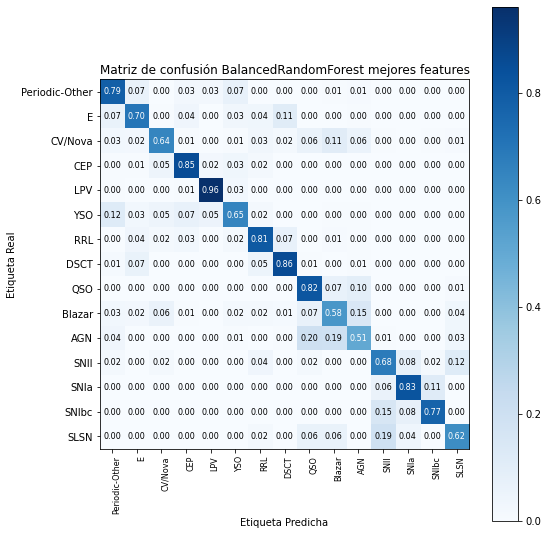

In [ ]:
start = timer()
# creación de los arreglos de atributos y clases
X_mejores_atributos_15 = df_mejores_atributos_15.drop(['objectId', "Clases",'predicted_class'], axis=1)
y_mejores_atributos_15 = np.array(df_mejores_atributos_15['predicted_class'].map(mapa_15features))

# separación en testeo y prueba
X_train_mejores_atributos_15, X_test_mejores_atributos_15, y_train_mejores_atributos_15, y_test_mejores_atributos_15 = train_test_split(X_mejores_atributos_15, y_mejores_atributos_15, test_size=0.33, random_state=66)

# se llama al clasificador
rfc_mejores_atributos_15 = BalancedRandomForestClassifier() 
# entrenamiento del modelo
rfc_mejores_atributos_15.fit(X_train_mejores_atributos_15,y_train_mejores_atributos_15)
# predicciones
rfc_predict_mejores_atributos_15 = rfc_mejores_atributos_15.predict(X_test_mejores_atributos_15)

#cross value
scores1_mejores_atributos_15 = cross_val_score(rfc_mejores_atributos_15, X_mejores_atributos_15, y_mejores_atributos_15, cv=4, scoring='accuracy')
print('Para el clasificador random forest:')
print('Cross validation promedio: ', format(scores1_mejores_atributos_15.mean(), '.3f'))
print('Cross validation std:      ', format(scores1_mejores_atributos_15.std(), '.3f'))
print("Accuracy:", metrics.accuracy_score(y_test_mejores_atributos_15, rfc_predict_mejores_atributos_15))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_mejores_atributos_15, rfc_predict_mejores_atributos_15))


#matriz de confusión 
plot_confusion_matrix(y_test_mejores_atributos_15, rfc_predict_mejores_atributos_15, classes=clases_15features, normalize = True,
                      title='Matriz de confusión BalancedRandomForest mejores features')
print('Tiempo que toma correrlo:')
end = timer()
print(end - start)

Se crea el DataFrame con los 42 atributos FATS 

In [ ]:
df_15features_FATS = df_22.copy().dropna()
print(df_15features_FATS.shape)

(190230, 44)


Se hace la clasificación para los 190000 objetos usando los atributos FATS considerando el tiempo que se demora en correr, el accuracy y el cross validation.

Para el clasificador random forest:
Cross validation promedio:  0.478
Cross validation std:       0.007
Accuracy: 0.4762648145788199
Balanced accuracy: 0.45642982449531605
Matriz de confusion normalizada
[[4.78848493e-01 9.56210299e-02 4.05460197e-04 4.66279227e-03
  5.68995810e-02 6.25760238e-02 1.55426409e-03 1.08798486e-01
  1.21502906e-01 1.17583457e-02 5.44668198e-02 3.37883498e-04
  7.43343695e-04 2.02730099e-04 1.62184079e-03]
 [8.60338101e-02 3.98127438e-01 5.61768531e-03 1.60416125e-01
  2.40312094e-02 9.93498049e-03 7.28738622e-02 1.96046814e-01
  2.18465540e-02 8.94668401e-03 1.21716515e-02 3.64109233e-04
  8.84265280e-04 5.20156047e-05 2.65279584e-03]
 [3.69843528e-02 2.13371266e-02 6.65718350e-01 1.99146515e-02
  1.99146515e-02 2.13371266e-02 1.42247511e-02 1.70697013e-02
  4.97866287e-02 5.12091038e-02 2.13371266e-02 5.68990043e-03
  7.11237553e-03 2.13371266e-02 2.70270270e-02]
 [2.51572327e-03 8.42767296e-02 8.30188679e-02 4.77987421e-01
  5.28301887e-02 3.77358491e-03 

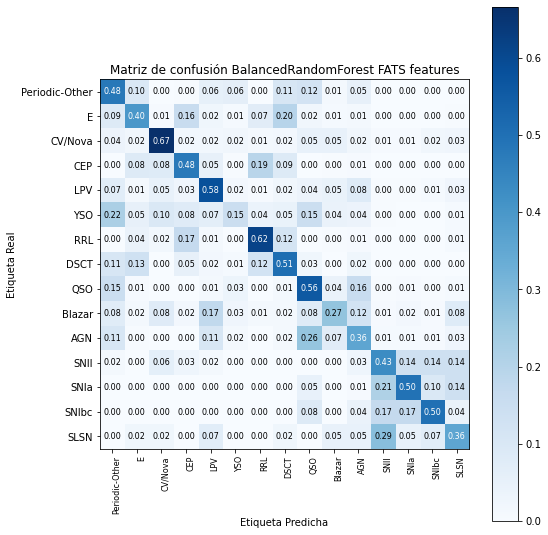

In [ ]:
start = timer()
# creación de los arreglos de atributos y clases
X_15features_FATS = df_15features_FATS.drop(['objectId', "Clases",'predicted_class'], axis=1)
y_15features_FATS = np.array(df_15features_FATS['predicted_class'].map(mapa_15features))

# separación en testeo y prueba
X_train_15features_FATS, X_test_15features_FATS, y_train_15features_FATS, y_test_15features_FATS = train_test_split(X_15features_FATS, y_15features_FATS, test_size=0.33, random_state=66)

# se llama al clasificador
rfc_15features_FATS = BalancedRandomForestClassifier() 
# entrenamiento del modelo
rfc_15features_FATS.fit(X_train_15features_FATS,y_train_15features_FATS)
# predicciones
rfc_predict_15features_FATS = rfc_15features_FATS.predict(X_test_15features_FATS)

#cross value
scores1_15features_FATS = cross_val_score(rfc_15features_FATS, X_15features_FATS, y_15features_FATS, cv=4, scoring='accuracy')
print('Para el clasificador random forest:')
print('Cross validation promedio: ', format(scores1_15features_FATS.mean(), '.3f'))
print('Cross validation std:      ', format(scores1_15features_FATS.std(), '.3f'))
print("Accuracy:", metrics.accuracy_score(y_test_15features_FATS, rfc_predict_15features_FATS))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_15features_FATS, rfc_predict_15features_FATS))


#matriz de confusión 
plot_confusion_matrix(y_test_15features_FATS, rfc_predict_15features_FATS, classes=clases_15features, normalize = True,
                      title='Matriz de confusión BalancedRandomForest FATS features')
print('Tiempo que toma correrlo:')
end = timer()
print(end - start)

# Links importantes
- SN Hunter https://snhunter.alerce.online/
- Python tutorial https://www.youtube.com/playlist?list=PLFA428AMRhwAfmfgEc4MP8m4PiNeqbxZv 

- OGLE Variable stars http://ogledb.astrouw.edu.pl/~ogle/CVS/
- Catalogs PUC http://kpichara.ing.puc.cl/project/1/
- Datos https://github.com/Wenupi/Datos_proyecto
- Paper AleRCE https://arxiv.org/pdf/2008.03311.pdf


# Referencias
1. DataFrame plot [link 1](https://sciencelee.medium.com/making-plots-with-the-pandas-groupby-ac492941af28)

2. Select random rows [link 2](https://cmdlinetips.com/2018/02/how-to-randomly-select-rows-in-pandas-pandas-tutorial/#:~:text=To%20randomly%20select%20rows%20from,sample%20with%20the%20argument%20n.&text=Every%20time%2C%20we%20run%20%E2%80%9Csample,rows%20from%20the%20Pandas%20dataframe.)

3. Concatenate dataframes [link 3](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html)

4. RandomForest [link 4](https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652)

5. Unbalanced classes [link 5](https://chrisalbon.com/machine_learning/trees_and_forests/handle_imbalanced_classes_in_random_forests/)

6. Features importance [link 6](https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e)

7. Imblearn [link 7](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedRandomForestClassifier.html#imblearn.ensemble.BalancedRandomForestClassifier.feature_importances_)